# 0. 구글드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 0.1 환경 설정

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization

from tensorflow.keras.optimizers import Adam

#1. 데이터 로드

In [ ]:
!cp '/gdrive/MyDrive/tmp/newdata/train_data.zip' ./
!cp '/gdrive/MyDrive/tmp/newdata/r_destroyed.zip' ./

In [ ]:
!ls -al

total 129952
drwxr-xr-x 1 root root      4096 Aug 13 19:58 .
drwxr-xr-x 1 root root      4096 Aug 13 19:54 ..
drwxr-xr-x 4 root root      4096 Aug  3 20:20 .config
-rw------- 1 root root   1066566 Aug 13 19:58 r_destroyed.zip
drwxr-xr-x 1 root root      4096 Aug  3 20:21 sample_data
-rw------- 1 root root 131984646 Aug 13 19:58 train_data.zip


In [ ]:
!unzip train_data.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_data/zoom_in4775.jpg  
  inflating: train_data/zoom_in4776.jpg  
  inflating: train_data/zoom_in4777.jpg  
  inflating: train_data/zoom_in4778.jpg  
  inflating: train_data/zoom_in4779.jpg  
  inflating: train_data/zoom_in4780.jpg  
  inflating: train_data/zoom_in4781.jpg  
  inflating: train_data/zoom_in4782.jpg  
  inflating: train_data/zoom_in4783.jpg  
  inflating: train_data/zoom_in4784.jpg  
  inflating: train_data/zoom_in4785.jpg  
  inflating: train_data/zoom_in4786.jpg  
  inflating: train_data/zoom_in4787.jpg  
  inflating: train_data/zoom_in4788.jpg  
  inflating: train_data/zoom_in4789.jpg  
  inflating: train_data/zoom_in4790.jpg  
  inflating: train_data/zoom_in4791.jpg  
  inflating: train_data/zoom_in4792.jpg  
  inflating: train_data/zoom_in4793.jpg  
  inflating: train_data/zoom_in4794.jpg  
  inflating: train_data/zoom_in4795.jpg  
  inflating: train_data/zoom_in4796.jpg  
  inflating: train_data/zoom_in4797.jpg 

In [ ]:
!unzip r_destroyed.zip

Archive:  r_destroyed.zip
  inflating: r_destroyed/d_01.jpg    
  inflating: r_destroyed/d_02.jpg    
  inflating: r_destroyed/d_03.jpg    
  inflating: r_destroyed/d_04.jpg    
  inflating: r_destroyed/d_05.jpg    
  inflating: r_destroyed/d_06.jpg    
  inflating: r_destroyed/d_07.jpg    
  inflating: r_destroyed/d_08.jpg    
  inflating: r_destroyed/d_09.jpg    
  inflating: r_destroyed/d_10.jpg    
  inflating: r_destroyed/d_11.jpg    
  inflating: r_destroyed/d_12.jpg    
  inflating: r_destroyed/d_13.jpg    
  inflating: r_destroyed/d_14.jpg    
  inflating: r_destroyed/d_15.jpg    
  inflating: r_destroyed/d_16.jpg    
  inflating: r_destroyed/d_17.jpg    
  inflating: r_destroyed/d_18.jpg    
  inflating: r_destroyed/d_19.jpg    
  inflating: r_destroyed/d_20.jpg    
  inflating: r_destroyed/d_21.jpg    
  inflating: r_destroyed/d_22.jpg    
  inflating: r_destroyed/d_23.jpg    
  inflating: r_destroyed/d_24.jpg    
  inflating: r_destroyed/d_25.jpg    
  inflating: r_destroyed

In [ ]:
zoomin_data = glob('train_data/*.jpg')
r_destroyed_data = glob('r_destroyed/*jpg')

In [ ]:
print(len(zoomin_data))
print(len(r_destroyed_data))

9774
29


# 2. 데이터 전처리

In [ ]:
# crop으로 128,128로 데이터 사이즈 조정

crop_zoomin = [] # 인풋에 들어가는 image 리스트 : Train data

for img in zoomin_data:
    img = load_img(img)
    img = img_to_array(img).astype('float32')/255
    y = 48
    h = 128
    x = 48
    w = 128
    crop_img = img[y: y + h, x: x + w]

    crop_zoomin.append(crop_img)

crop_zoomin = np.array(crop_zoomin)
crop_zoomin.shape

(9774, 128, 128, 3)

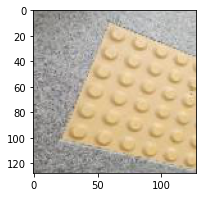

In [ ]:
# check
plt.figure(figsize=(3, 3))
plt.imshow(crop_zoomin[1])
plt.show()

In [ ]:
# crop으로 128,128로 데이터 사이즈 조정

r_destroyed = []

for img in r_destroyed_data:
  img = load_img(img)
  img = img_to_array(img).astype('float32')/255
  y = 48
  h = 128
  x = 48
  w = 128
  crop_img = img[y: y + h, x: x + w]
  r_destroyed.append(crop_img)

r_destroyed = np.array(r_destroyed)

In [ ]:
# train and test split
train_x, test_n = train_test_split(crop_zoomin, test_size=0.1, shuffle=True, random_state=42)

In [ ]:
print(train_x.shape)
print(test_n.shape)

(8796, 128, 128, 3)
(978, 128, 128, 3)


In [ ]:
# 테스트셋 생성(978개 정상 데이터, 29개 이상치)
test_x = np.vstack([test_n, r_destroyed])
test_x.shape

(1007, 128, 128, 3)

In [ ]:
# y_label 생성

y_n = np.zeros(978)
y_a = np.ones(29)

y_label = np.concatenate((y_n, y_a))
print(y_label.shape)

(1007,)


#3. 모델 생성

In [ ]:
model = Sequential()

model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2), padding="same"))

model.add(Dense(2))

model.add(Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(Conv2D(3, (1, 1), activation="sigmoid", padding="same"))




model.compile(optimizer='adam', loss='mse', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                    

# 4. 모델 학습

In [ ]:
# auto encoder : use model.fit(train_data, train_data, ....)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=50)
hist = model.fit(train_x, train_x, epochs=400, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/400
495/495 [==============================] - 33s 40ms/step - loss: 0.0110 - accuracy: 0.9438 - val_loss: 0.0079 - val_accuracy: 0.9400
Epoch 2/400
495/495 [==============================] - 19s 39ms/step - loss: 0.0063 - accuracy: 0.9273 - val_loss: 0.0055 - val_accuracy: 0.9153
Epoch 3/400
495/495 [==============================] - 19s 39ms/step - loss: 0.0051 - accuracy: 0.9111 - val_loss: 0.0058 - val_accuracy: 0.9316
Epoch 4/400
495/495 [==============================] - 19s 39ms/step - loss: 0.0050 - accuracy: 0.9136 - val_loss: 0.0051 - val_accuracy: 0.9079
Epoch 5/400
495/495 [==============================] - 19s 39ms/step - loss: 0.0050 - accuracy: 0.9168 - val_loss: 0.0054 - val_accuracy: 0.9162
Epoch 6/400
495/495 [==============================] - 19s 39ms/step - loss: 0.0048 - accuracy: 0.9223 - val_loss: 0.0049 - val_accuracy: 0.9408
Epoch 7/400
495/495 [==============================] - 19s 39ms/step - loss: 0.0047 - accuracy: 0.9243 - val_loss: 0.0049 - val_ac

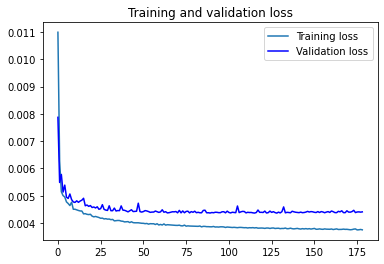

In [ ]:
# plot loss history
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(loss))


plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#5. 모델 저장 및 불러오기

In [ ]:
model.save("ae_bottleneck_16_179epoch.h5")

In [ ]:
from tensorflow.keras.models import load_model
model= load_model("/gdrive/MyDrive/tmp/newdata/ae_bottleneck_16_179epoch.h5")

#6. 복원 실행

In [ ]:
reconstructed = model.predict(train_x)

In [ ]:
reconstructed_test = model.predict(test_x)

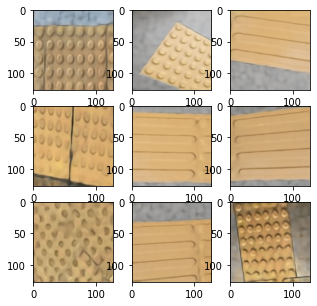

In [ ]:
# train_x 복원 확인하기

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(reconstructed[i].reshape((128,128,3)))

plt.show()

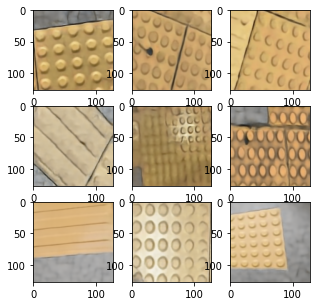

In [ ]:
# test_x 복원 확인하기

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(reconstructed_test[i].reshape((128,128,3)))

plt.show()

# 7. range를 이상치 판단 기준으로 하여 0.99 범위수의 threshold 구하기

## 범위값 구하기

In [ ]:
# residual range로 anormaly detection
errors_range = []

for (image, recon) in zip(train_x, reconstructed):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
  tmp = image - recon
  rge = np.max(tmp) - np.min(tmp) #rge == range
  errors_range.append(rge)


In [ ]:
errors_range = np.array(errors_range)

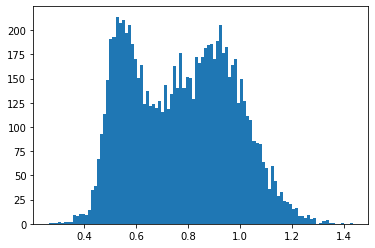

In [ ]:
plt.hist(errors_range, bins=100)
plt.show()

In [ ]:
errors_range_test = []

for (image, recon) in zip(test_x, reconstructed_test):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	tmp = image - recon
	rge = np.max(tmp) - np.min(tmp) #rge == range
	errors_range_test.append(rge)

In [ ]:
errors_range_test = np.array(errors_range_test)

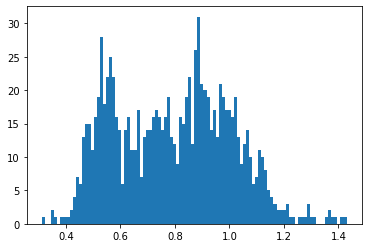

In [ ]:
plt.hist(errors_range_test, bins=100)
plt.show()

## threshold 결정

In [ ]:
threshold = np.quantile(errors_range, 0.99)
print(threshold)

1.198503541946411


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

f1score = f1_score(y_label, errors_range_test > threshold, pos_label=0) # true class, prediction, positive value
# 논리연산이 true인 경우 1을 출력하므로 threshold_r보다 큰 이상치의 경우가 1이 되도록
rocaucscore = roc_auc_score(y_label, errors_range_test)
accscore = accuracy_score(y_label, errors_range_test > threshold)

print(f1score)
print(rocaucscore)
print(accscore)

0.9903209373408048
0.9402369367463508
0.9811320754716981


## 이상치탐지

In [ ]:
# 이상치 탐지
anomaly_idxs = np.where(np.array(errors_range_test) >= threshold)[0]
print(len(anomaly_idxs))

22


In [ ]:
# 탐지된 이미지 확인
normal_count = 0
anomaly_count = 0

for i in anomaly_idxs:
  if i <=977:
    normal_count +=1
  else:
    anomaly_count +=1

  combined = np.hstack([test_x[i], reconstructed_test[i]])
  plt.imshow(combined.squeeze())
  plt.show()

print("normal count: %d" %normal_count)
print("anomaly count: %d" %anomaly_count)

Output hidden; open in https://colab.research.google.com to view.

In [40]:
error_df = pd.DataFrame({'Reconstruction_error': errors_range_test, 
                         'True_class':list(y_label)})

In [41]:
error_df.head()

,Reconstruction_error,True_class
0,0.884143,0.0
1,0.743820,0.0
2,0.721436,0.0
3,1.128641,0.0
4,1.083937,0.0


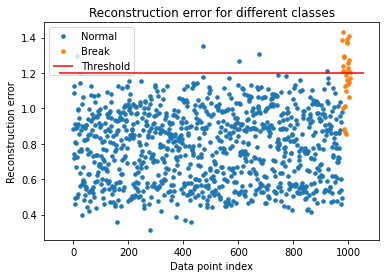

In [42]:
# reconstruction error 그래프 그리기
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

#8. confusion matrix로 표현

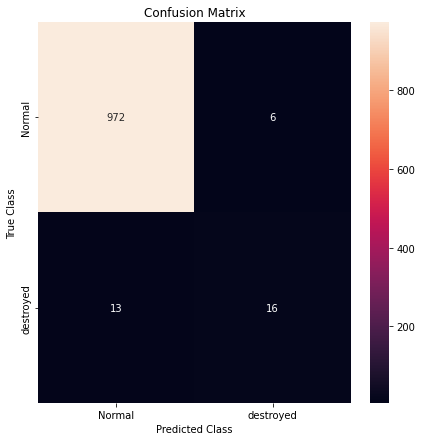

In [43]:
# threshold를 기준으로 했을때 confusion matrix
LABELS = ['Normal', 'destroyed']

pred_y = [1 if e > threshold else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

#9. ROC Curve & AUC

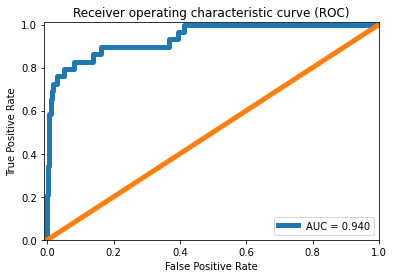

In [44]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)


plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()

#10. precision, recall, f1 score

In [47]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

f1score = f1_score(y_label, errors_range_test > threshold, pos_label=0) # true class, prediction, positive value
# 논리연산이 true인 경우 1을 출력하므로 threshold_r보다 큰 이상치의 경우가 1이 되도록
recallscore = recall_score(y_label, errors_range_test > threshold, pos_label=0)
precisionscore = precision_score(y_label, errors_range_test > threshold, pos_label=0)

rocaucscore = roc_auc_score(y_label, errors_range_test)

print("f1 score : %0.4f" %f1score)
print("recall score : %0.4f" %recallscore)
print("precision score : %0.4f" %precisionscore)
print("auc score : %0.4f" %rocaucscore)

f1 score : 0.9903
recall score : 0.9939
precision score : 0.9868
auc score : 0.9402


#(번외) tflite로 변환해서 저장

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("ae_bottleneck_16_179epoch.tflite", "wb").write(tflite_model)

3091256

In [ ]:
import os

def findfile(name, path):
    for dirpath, dirname, filename in os.walk(path):
        if name in filename:
            return os.path.join(dirpath, name)
filepath = findfile("ae_bottleneck_16_179epoch.tflite", "/")
print(filepath)

/content/ae_bottleneck_16_179epoch.tflite
